In [1]:
########
#
# in this script we will read in some ERA5 data and then country mask it.
# For all years from 1979-2020
#
# This script is a simple starter script, it can be adapted to read in
# multiple years of data or to read in different fields. 
# 
# Other functions are also available to load the data in the libraries: 
# - cfpython 
# - xarray
# - iris
#
#########

import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import cartopy.io.shapereader as shpreader
import shapely.geometry


def load_country_mask(COUNTRY,data_dir,filename,nc_key):

    '''

    This function loads the country masks for the ERA5 data grid we have been using

    Args:
        COUNTRY (str): This must be a name of a country (or set of) e.g. 
            'United Kingdom','France','Czech Republic'
 
       data_dir (str): The parth for where the data is stored.
            e.g '/home/users/zd907959/'

        filename (str): The filename of a .netcdf file
            e.g. 'ERA5_1979_01.nc'

        nc_key (str): The string you need to load the .nc data 
            e.g. 't2m','rsds'

    Returns:
       MASK_MATRIX_RESHAPE (array): Dimensions [lat,lon] where there are 1's if 
           the data is within a country border and zeros if data is outside a 
           country border. 


    '''


    # first loop through the countries and extract the appropraite shapefile
    countries_shp = shpreader.natural_earth(resolution='10m',category='cultural',
                                            name='admin_0_countries')
    country_shapely = []
    for country in shpreader.Reader(countries_shp).records():
        if country.attributes['NAME_LONG'] == COUNTRY:
            print('Found country')
            country_shapely.append(country.geometry)

    # load in the data you wish to mask
    file_str = data_dir + filename
    dataset = Dataset(file_str,mode='r')
    lons = dataset.variables['longitude'][:]
    lats = dataset.variables['latitude'][:]
    data = dataset.variables[nc_key][:] # data in shape [time,lat,lon]
    dataset.close()

    # get data in appropriate units for models
    if nc_key == 't2m':
        data = data-273.15 # convert to Kelvin from Celsius
    if nc_key == 'ssrd':
        data = data/3600. # convert Jh-1m-2 to Wm-2

    LONS, LATS = np.meshgrid(lons,lats) # make grids of the lat and lon data
    x, y = LONS.flatten(), LATS.flatten() # flatten these to make it easier to 
    #loop over.
    points = np.vstack((x,y)).T
    MASK_MATRIX = np.zeros((len(x),1))
    # loop through all the lat/lon combinations to get the masked points
    for i in range(0,len(x)):
        my_point = shapely.geometry.Point(x[i],y[i]) 
        if country_shapely[0].contains(my_point) == True: 
            MASK_MATRIX[i,0] = 1.0 # creates 1s and 0s where the country is
    
    MASK_MATRIX_RESHAPE = np.reshape(MASK_MATRIX,(len(lats),len(lons)))


    return(MASK_MATRIX_RESHAPE)

In [4]:
def load_country_weather_data(MASK_MATRIX_RESHAPE, data_dir,filename,nc_key):
   
    '''
    
    This functions takes the ERA5 reanalysis data, loads it and applies a 
    pre-loaded country mask. It then takes the mean over that country mask
    and returns a time series of the data.
    
    Note tha unit conversions are currently only implemented for nc_keys of 't2m'
    and 'ssrd'
    
    Args:
    
    MASK_MATRIX_RESHAPE (array): Dimensions [lat,lon]. where there are 1s within a 
        country border and zeros outside it.
        
    data dir (str): the path for where the data is stored
    
    filename (str): the filesname of a .netcdf (.nc) file
    
    nc_key (str) : the string you need to load the .nc file e.g. 't2m' or 'ssrd'
    
    Returns:
    
    country_timeseries (array): Timeseries of country masked weather data
    dimensions [time].
    
    lats (array): latitudes of the original array of weather data
    
    lons (array): longitudes of the original array of weather data
    
    
    
    '''
    
    filestr = data_dir + filename
    dataset = Dataset(filestr,mode='r')
    lons = dataset.variables['longitude'][:]
    lats = dataset.variables['latitude'][:]
    data = dataset.variables[nc_key][:]
    dataset.close()
    
    if nc_key == 't2m':
        data = data-273.15 # convert from K to degCelsius
    if nc_key == 'ssrd':
        data = data/3600. #convert Jh-1m-2 to Wm-2
        
    country_masked_data = np.zeros(np.shape(data))
    for i in range(0,len(country_masked_data)):
        country_masked_data[i,:,:] = data[i,:,:]*MASK_MATRIX_RESHAPE
        
    country_masked_data[country_masked_data ==0.] = np.nan
    
    country_timeseries=np.nanmean(np.nanmean(country_masked_data,axis=2),axis=1)
                                 
    return(country_timeseries,lats,lons)
    

Found country


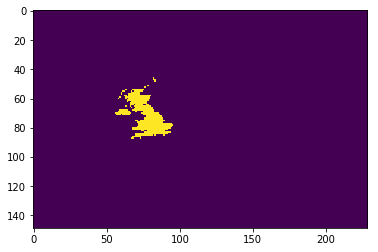

In [6]:
country_mask = load_country_mask('United Kingdom','/gws/pw/j05/cop26_hackathons/oxford/Data/ERA5_data_EU_domain/field_set_1/','ERA5_1hr_field_set_1_2018_01.nc','t2m')
plt.imshow(country_mask)
plt.show()

In [5]:
ERA5_t2m_data = np.zeros([2021-1979,8760]) #number of years, number of hours in a standard year

for qyear in range(1979,1980): # loop over the years
    
    aggregate_t2m = []
    print(qyear)
    for qmonth in range(1,13): # loop over the months
        print(qmonth)
        qmonthchar = str(qmonth).zfill(2)
        qyearchar = str(qyear)
        
        file_loc = '/gws/pw/j05/cop26_hackathons/oxford/Data/ERA5_data_EU_domain/field_set_1/'
        file_name = 'ERA5_1hr_field_set_1_' + qyearchar + '_' + qmonthchar + '.nc' 
        
        t2m_data,lats,lons =load_country_weather_data(country_mask,file_loc,file_name,'t2m')
        
        aggregate_t2m.append(t2m_data)
      
    temp_data = np.array([item for sublist in aggregate_t2m for item in sublist])
    ERA5_t2m_data[qyear-1979,:] = np.array(temp_data)

1979
1


NameError: name 'country_mask' is not defined

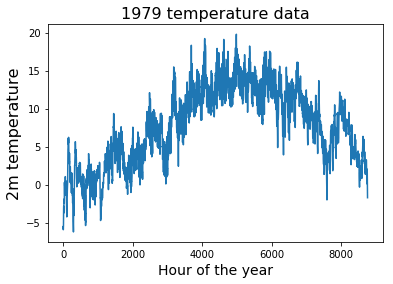

In [20]:
plt.plot(ERA5_t2m_data[0,:])
plt.xlabel('Hour of the year',fontsize=14)
plt.ylabel('2m temperature',fontsize=16)
plt.title('1979 temperature data',fontsize=16)
plt.show()
